### Setting up a pre-trained BERT model for fine-tuning:

#### Load project modules and data

We will use basic python packages.

We will compare this pre-trained cloud model to the baseline model from 2_baseline.ipynb.

### Load project modules and data

We will use basic python packages.

In [4]:
# Import custom helper libraries
import os
import sys
import sys, os, re, csv, codecs
import pickle

# Maths modules
import numpy as np
import pandas as pd
from numpy import exp
from numpy.core.fromnumeric import repeat, shape  # noqa: F401,W0611
from scipy.stats import f_oneway

# Viz modules
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
%matplotlib inline

# Render for export
import plotly.io as pio
pio.renderers.default = "notebook"
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import plotly.figure_factory as ff

#Sklearn modules
from sklearn import metrics
from sklearn.metrics import (ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,)
from sklearn.metrics import (confusion_matrix, roc_auc_score, average_precision_score, classification_report)
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score)
from sklearn.base import ClassifierMixin, is_classifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# System modules
import random
import contractions
import re
import time
from collections import Counter
from collections import defaultdict
from unidecode import unidecode
import logging
from typing import Callable, Dict, List, Optional, Tuple, Union
import gc
from random import shuffle
import itertools

# ML modules
from tqdm import tqdm
tqdm.pandas()

# NLTK modules
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Keras modules
import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, BatchNormalization, TimeDistributed, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
# from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D)
# from keras.optimizers import Adam

# Tensoflow modules
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

# Transformers
from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import TFAutoModelForSequenceClassification, BertConfig

import plotly.figure_factory as ff
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
from random import randrange



In [5]:
import session_info
session_info.show()

#### Load sampled data

In [2]:
# Load data from CSV
df = pd.read_csv(r"C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_7\\data\\raw\\sentiment140_16000_tweets.csv",
                 names=["target", "text"], encoding='latin-1')

# Drop useless raw
df = df.iloc[1: , :]

df.describe(include="all")

,target,text
count,16000,16000
unique,2,15987
top,NEGATIVE,isPlayer Has Died! Sorry
freq,8000,5


#### Text preprocessing

The text is transformed to tensors with AutoTokenizer.

In [3]:
df.target.replace(
    {
        "NEGATIVE": 0,
        "POSITIVE": 1,
    },
    inplace=True,
)

In [4]:
data = df.copy()

In [5]:
import transformers
print(transformers.__version__)

4.6.1


In [6]:
data

,target,text
1,0,@xnausikaax oh no! where did u order from? tha...
2,0,A great hard training weekend is over. a coup...
3,0,"Right, off to work Only 5 hours to go until I..."
4,0,I am craving for japanese food
5,0,Jean Michel Jarre concert tomorrow gotta work...
...,...,...
15996,1,my video is about mileys latest movie &quot;th...
15997,1,Had a great birthday yesterday....peaceful and...
15998,1,Just had lovely lunch with girls from work sit...
15999,1,my cousin @PinkMordeno and i are watching the ...


In [7]:
# Tokenizers, Stemmers and Lemmatizers

BERT_MODEL = "bert-base-uncased"  # "vinai/bertweet-base"
MAX_LENGTH = 50

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

input_ids = np.asarray(
    [
        tokenizer(sent, max_length=MAX_LENGTH, padding="max_length", truncation=True)[
            "input_ids"
        ]
        for sent in tqdm(data.text)
    ]
)
attention_mask = np.asarray(
    [
        tokenizer(sent, max_length=MAX_LENGTH, padding="max_length", truncation=True)[
            "attention_mask"
        ]
        for sent in tqdm(data.text)
    ]
)
token_type_ids = np.asarray(
    [
        tokenizer(sent, max_length=MAX_LENGTH, padding="max_length", truncation=True)[
            "token_type_ids"
        ]
        for sent in tqdm(data.text)
    ]
)

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:03<00:00, 4900.35it/s]


In [8]:
data.text.values

array(["@xnausikaax oh no! where did u order from? that's horrible ",
       'A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now ',
       "Right, off to work  Only 5 hours to go until I'm free xD", ...,
       'Just had lovely lunch with girls from work sitting outside at Prezzo. We also have crispy creme for later ',
       "my cousin @PinkMordeno and i are watching the video of our grandpa &amp; grandma's 50th wedding anniversary! ",
       'Photo: my birthday meaaal  http://tumblr.com/xsz21uo3r'],
      dtype=object)

In [9]:
# Train-test split
(
    texts_train,
    texts_test,
    input_ids_train,
    input_ids_test,
    attention_mask_train,
    attention_mask_test,
    token_type_ids_train,
    token_type_ids_test,
    labels_train,
    labels_test,
) = train_test_split(
    data.text.values,
    input_ids,
    attention_mask,
    token_type_ids,
    data.target.values,
    test_size=0.2,
    stratify=data.target.values,
    random_state=42,
)

In [10]:
texts_train

array(['Exam return day, overall average of 86.5%  WORK HARDER NEXT TIME CRYSTAL AND NO SLACK. Astronomy night tonight and team dinner tomorrow!',
       "Out of school. I'm going to miss everyone so much!  &lt;3",
       '@WerewolfEmbry ', ...,
       'Ok seriously I need a new agent.  Watch this space tweeps im goin2 the top!',
       '@zerosandones I like the look of that eeeBuntu, hopefully @iancleary can help me install it on my S101 ',
       'waiting, waiting, waiting '], dtype=object)

In [11]:
# Train-val split
(
    texts_train,
    texts_val,
    input_ids_train,
    input_ids_val,
    attention_mask_train,
    attention_mask_val,
    token_type_ids_train,
    token_type_ids_val,
    labels_train,
    labels_val,
) = train_test_split(
    texts_train,
    input_ids_train,
    attention_mask_train,
    token_type_ids_train,
    labels_train,
    test_size=0.1,
   #stratify=labels_train,
    #random_state=42,
)

In [ ]:
print("X_train shape: {}".format(texts_train.shape))
print("X_test shape: {}".format(texts_test.shape))
print("y_train shape: {}".format(labels_train.shape))
print("y_test shape: {}".format(labels_test.shape))
print("X_val shape: {}".format(texts_val.shape))
print("y_val shape: {}".format(labels_val.shape))

### Model fine-tuning
We are going to fit the TFAutoModelForSequenceClassification in order to adapt it to our dataset.

In [13]:
# Define NN model
print("Defining model...")
model = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)#,config=config )


# compile NN network
print("Compiling model...")
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=2e-5),  # Value recommended by the Bert team
    metrics=BinaryAccuracy(),
)

# fit NN model
print("Fitting model...")
model.fit(
    [input_ids_train, attention_mask_train, token_type_ids_train],
    labels_train,
    epochs=10,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3),
    ],
    workers=4,
    use_multiprocessing=True,
)

print(model.summary())

Defining model...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compiling model...
Fitting model...
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x0000020DDDDF45C0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x0000020DDDDF45C0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1152/1152 [==============================] - 224

#### Results and evaluation
We tried to fine-tune two different models, and we will compare the results : the standard BERT model, and the more adapted to english tweets BERTweet model.

#### Vanilla BERT model : bert-base-uncased

##### Validation data set

In [16]:
y_pred = model.predict(
    [input_ids_val, 
     attention_mask_val, 
     token_type_ids_val],
    )
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred.logits)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred.logits)]

In [18]:
x_axes = ['NEGATIVE', 'POSITIVE']
y_axes = ['POSITIVE', 'NEGATIVE']  

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = {},
                      yaxis = {}
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

              precision    recall  f1-score   support

    NEGATIVE       0.30      0.38      0.33       650
    POSITIVE       0.11      0.08      0.10       630

    accuracy                           0.23      1280
   macro avg       0.21      0.23      0.21      1280
weighted avg       0.21      0.23      0.22      1280

ROC AUC score :  0.229
Average Precision score :  0.461


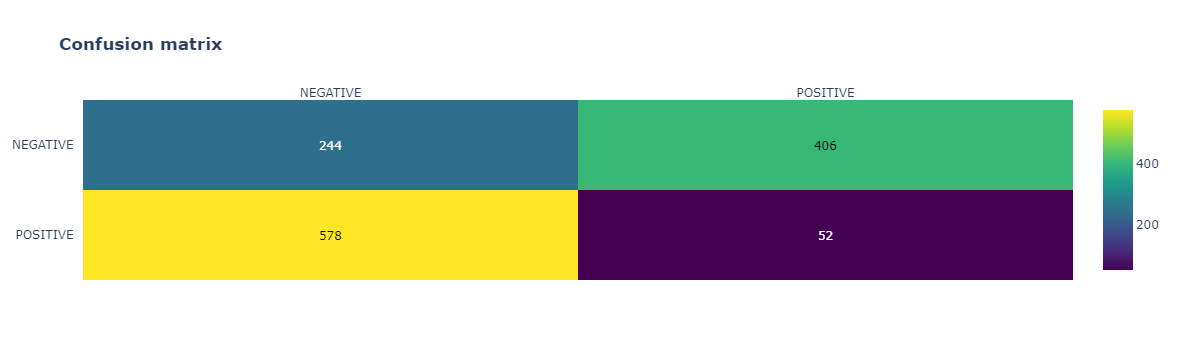

In [20]:
target_names = ['NEGATIVE', 'POSITIVE']
print(classification_report(labels_val, y_pred_label, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(labels_val, y_pred_label), 3))
print("Average Precision score : ", round(average_precision_score(labels_val, y_pred_label), 3),)
conf_matrix(metrics.confusion_matrix(labels_val, y_pred_label))

##### Test data set

In [22]:
y_pred = model.predict(
    [input_ids_test, 
     attention_mask_test, 
     token_type_ids_test]
    )
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred.logits)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred.logits)]

              precision    recall  f1-score   support

    NEGATIVE       0.27      0.34      0.30      1600
    POSITIVE       0.11      0.08      0.09      1600

    accuracy                           0.21      3200
   macro avg       0.19      0.21      0.20      3200
weighted avg       0.19      0.21      0.20      3200

ROC AUC score :  0.211
Average Precision score :  0.469


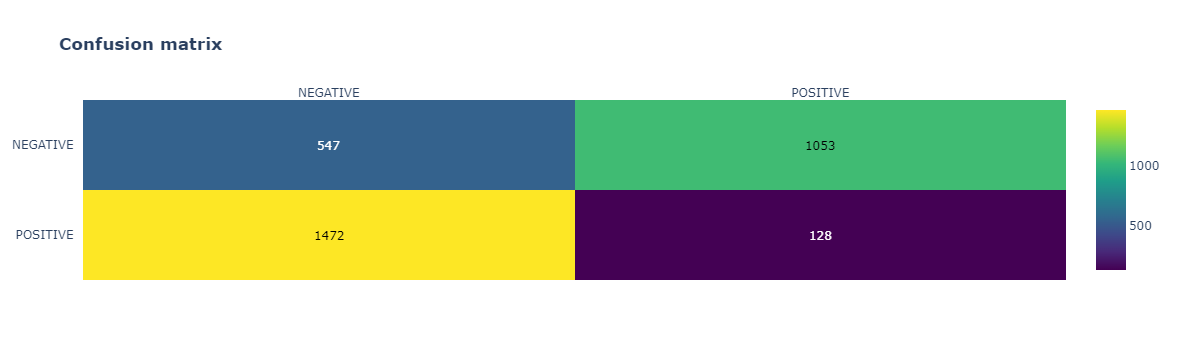

In [25]:
target_names = ['NEGATIVE', 'POSITIVE']
print(classification_report(labels_test, y_pred_label, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(labels_test, y_pred_label), 3))
print("Average Precision score : ", round(average_precision_score(labels_test, y_pred_label), 3),)
conf_matrix(metrics.confusion_matrix(labels_test, y_pred_label))

In [26]:
idx = randrange(len(texts_test))

print("Text : ", texts_test[idx])
print("True sentiment : ", labels_test[idx])
print("Predicted sentiment : ", round(y_pred_proba[idx], 3))

Text :  @peoplemag not yet!! man i suck  i promise to see it this week
True sentiment :  0
Predicted sentiment :  0.504


### English tweets adapted model : vinai/bertweet-base

This run failed in the end, but the results are still available in the logs :

In [27]:
BERT_MODEL = "vinai/bertweet-base"  
MAX_LENGTH = 200

In [28]:
# Define NN model
print("Defining model...")
model_auto = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)

# compile NN network
print("Compiling model...")
model_auto.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=2e-5),  # Value recommended by the Bert team
    metrics=BinaryAccuracy(),
)

# fit NN model
print("Fitting model...")
model_auto.fit(
    [input_ids_train, attention_mask_train, token_type_ids_train],
    labels_train,
    epochs=10,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3),
    ],
    workers=4,
    use_multiprocessing=True,
)

print(model_auto.summary())

Defining model...


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compiling model...
Fitting model...
Epoch 1/10
1152/1152 [==============================] - 263s 220ms/step - loss: 0.6901 - binary_accuracy: 0.5661 - val_loss: 0.6286 - val_binary_accuracy: 0.6452
Epoch 2/10
1152/1152 [==============================] - 301s 261ms/step - loss: 0.6206 - binary_accuracy: 0.6604 - val_loss: 0.6017 - val_binary_accuracy: 0.7012
Epoch 3/10
1152/1152 [==============================] - 308s 268ms/step - loss: 0.5685 - binary_accuracy: 0.7178 - val_loss: 0.5966 - val_binary_accuracy: 0.7177
Epoch 4/10
1152/1152 [==============================] - 315s 273ms/step - loss: 0.5742 - binary_accuracy: 0.7160 - val_loss: 0.7956 - val_binary_accuracy: 0.7276
Epoch 5/10
1152/1152 [==============================] - 247s 214ms/step - loss: 0.4646 - binary_accuracy: 0.8026 - val_loss: 0.7815 - val_binary_accuracy: 0.7337
Epoch 6/10
1152/1152 [==============================] - 251s 218ms/step - loss: 0.4429 - binary_accuracy: 0.8155 - val_loss: 0.6491 - val_binary_accuracy:

##### Validation data set

In [29]:
y_pred = model_auto.predict([input_ids_val, attention_mask_val, token_type_ids_val])
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred.logits)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred.logits)]

In [31]:
x_axes = ['NEGATIVE', 'POSITIVE']
y_axes = ['POSITIVE', 'NEGATIVE']  

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = {},
                      yaxis = {}
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.62      0.68       650
    POSITIVE       0.67      0.80      0.73       630

    accuracy                           0.71      1280
   macro avg       0.71      0.71      0.71      1280
weighted avg       0.72      0.71      0.70      1280

ROC AUC score :  0.708
Average Precision score :  0.634


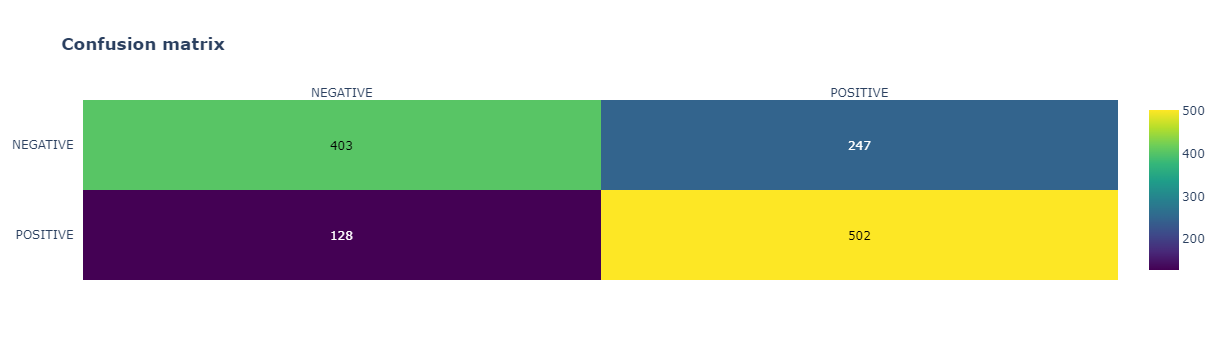

In [33]:
target_names = ['NEGATIVE', 'POSITIVE']
print(classification_report(labels_val, y_pred_label, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(labels_val, y_pred_label), 3))
print("Average Precision score : ", round(average_precision_score(labels_val, y_pred_label), 3),)
conf_matrix(metrics.confusion_matrix(labels_val, y_pred_label))

##### Test data set

In [36]:
y_pred = model_auto.predict(
    [input_ids_test, 
        attention_mask_test, 
        token_type_ids_test]
        )
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred.logits)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred.logits)]

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.65      0.70      1600
    POSITIVE       0.70      0.79      0.74      1600

    accuracy                           0.72      3200
   macro avg       0.73      0.72      0.72      3200
weighted avg       0.73      0.72      0.72      3200

ROC AUC score :  0.723
Average Precision score :  0.655


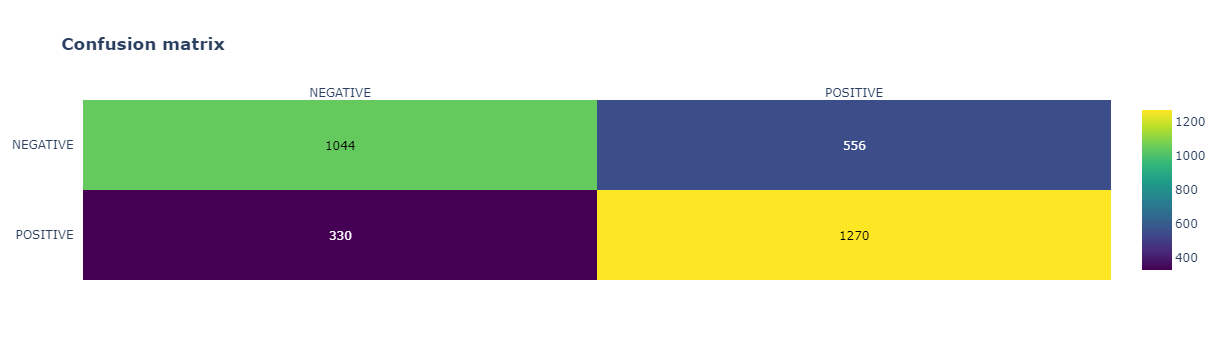

In [41]:
target_names = ['NEGATIVE', 'POSITIVE']
print(classification_report(labels_test, y_pred_label, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(labels_test, y_pred_label), 3))
print("Average Precision score : ", round(average_precision_score(labels_test, y_pred_label), 3),)
conf_matrix(metrics.confusion_matrix(labels_test, y_pred_label))

In [46]:
idx = randrange(len(texts_test))

print("Text : ", texts_test[idx])
print("True sentiment : ", labels_test[idx])
print("Predicted sentiment : ", round(y_pred_proba[idx], 5))

Text :  getting ready for Jonathan Coulton (and Paul and Storm) in Atlanta! Hoping for First of May&quot;  #jocorequests
True sentiment :  1
Predicted sentiment :  0.50409


### Conclusions
The performances on the dataset are slightly worst than our baseline model :

**Vanilla BERT Model**

* Average Precision = 0.461 (baseline = 0.65)
* ROC AUC = 0.229 (baseline = 0.66)

**Vinai/bertweet-base Model**

* Average Precision = 0.634 (baseline = 0.65 , -2.3%)
* ROC AUC = 0.708 (baseline = 0.66 , +7.27%)

Our model is also biased towards the POSITIVE.